In [1]:
import torch
import torch.backends.cudnn as cudnn
device = torch.cuda.set_device('cuda:1')
import matplotlib.pyplot as plt
from skimage.io import imread 
from skimage.transform import resize
import numpy as np
from utils import *

In [2]:
import archs

In [3]:
model = archs.NestedUNet(1, 3, False)

In [4]:
model = model.cuda()

In [5]:
#Load save model
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [6]:
model.eval()

NestedUNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (up): Upsample(scale_factor=2.0, mode=bilinear)
  (conv0_0): VGGBlock(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv1_0): VGGBlock(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2_0): VGGBlock(
    (relu): ReLU(inplace=True)
    

In [7]:
network_size = (256,256,3)

In [8]:
overlap = 0

In [71]:
image = imread('/data/spacenet/bldg/data/validation/MUL/MUL-PanSharpen_AOI_2_Vegas_img1016.tif')
image = np.array((image[:,:,[4,2,1]]/(image[:,:,[4,2,1]].max()+1e-10)), dtype=np.float32)
image = np.array(image*256, dtype=np.uint8)
#image = resize(image, (256, 256, 3))
#img = img.astype('float32') / 255


In [73]:
image_size = list(image.shape[0:2]) #Get image size and push to a list
tile_size = list(network_size[0:2]) #Get tile size as first two dimensions of network_size
        
corners = find_corners(image_size, tile_size, network_size, overlap)

tilesArr = create_tiles(image, corners, network_size)
tilesArr = tilesArr.astype('float32')
tilesArr = tilesArr.transpose(0, 3, 1, 2)
tilesArr = torch.from_numpy(tilesArr)
tilesArr = tilesArr.cuda()

In [72]:
image.shape

(650, 650, 3)

In [74]:
tilesArr.shape

torch.Size([9, 3, 256, 256])

In [54]:
image = imread('/data/spacenet/bldg/data/validation/MUL/MUL-PanSharpen_AOI_2_Vegas_img1023.tif')
img = np.array((image[:,:,[4,2,1]]/(image[:,:,[4,2,1]].max()+1e-10)), dtype=np.float32)
img = np.array(img*255, dtype=np.uint8)
img = resize(img, (256, 256, 3))


img = img.astype('float32') / 255
img = img.transpose(2, 0, 1)
img = img.reshape(1,3,256,256)
img = torch.from_numpy(img)
img = img.cuda()
print(type(img))

<class 'torch.Tensor'>


In [87]:
with torch.no_grad():
    #output = model(tilesArr)
    output = model(img)
    output = torch.sigmoid(output).cpu().numpy()

In [88]:
output.shape

(1, 1, 256, 256)

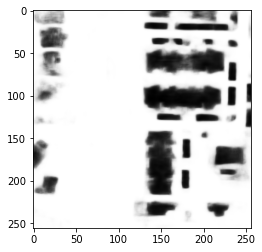

In [89]:
plt.imshow(output[0,0,:,:], cmap = 'gray')

In [34]:
output[0,0, 40:50,40:50]

array([[0.99633515, 0.99840087, 0.9990318 , 0.9994802 , 0.9996567 ,
        0.99968207, 0.9996965 , 0.9996605 , 0.99964094, 0.9995999 ],
       [0.9967961 , 0.99837863, 0.99911565, 0.99959975, 0.9997553 ,
        0.99978024, 0.99975604, 0.99970335, 0.9996278 , 0.99961406],
       [0.99701   , 0.9985821 , 0.99928015, 0.99964166, 0.9997813 ,
        0.99981636, 0.9998123 , 0.99978656, 0.99974066, 0.9997024 ],
       [0.99712986, 0.99882036, 0.9993975 , 0.9996834 , 0.9998067 ,
        0.99983335, 0.9998512 , 0.99985254, 0.9998623 , 0.99983513],
       [0.9972218 , 0.99872607, 0.9993261 , 0.999673  , 0.9997893 ,
        0.99980646, 0.9998443 , 0.9998723 , 0.9999074 , 0.99991214],
       [0.9975132 , 0.99873275, 0.9991842 , 0.9995572 , 0.9997111 ,
        0.99977773, 0.9998216 , 0.99988925, 0.99993455, 0.9999379 ],
       [0.99753904, 0.998058  , 0.99852556, 0.99911743, 0.9994598 ,
        0.99967706, 0.9997943 , 0.9998808 , 0.9999027 , 0.9999069 ],
       [0.99740654, 0.9974044 , 0.9976019

In [19]:
torch.cuda.empty_cache()

In [38]:
import cv2
cv2.imwrite('test.jpg',(output[0, 0] * 255).astype('uint8'))

True

In [80]:
final = assemble_pred(output, corners, image, network_size)

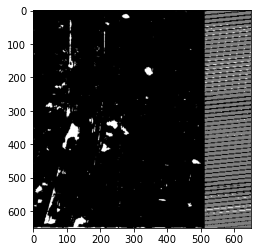

In [86]:
plt.imshow(final, cmap = 'gray')